In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn import tree
import pydotplus
import graphviz 

In [3]:
df = pd.read_csv('merged_dataset1.csv')

In [4]:
df.head()

,passenger_count,trip_distance,RatecodeID,payment_type,tip_amount,total_amount,trip_duration,date,PRCP,SNOW,pickup_borough,dropoff_borough,Tavg,tpep_pickup_time,tpep_dropoff_time
0,1,3.79,1.0,1,4.06,24.36,20.483333,2022-12-14,0.00,0.0,Manhattan,Manhattan,35.0,08:57:09,09:17:38
1,1,2.08,1.0,1,2.56,15.36,10.816667,2022-08-28,0.00,0.0,Manhattan,Manhattan,77.5,13:22:42,13:33:31
2,3,2.08,1.0,1,2.00,18.30,17.166667,2022-07-29,0.10,0.0,Manhattan,Manhattan,78.5,18:28:00,18:45:10
3,1,18.24,2.0,1,0.00,60.60,28.983333,2022-07-26,0.00,0.0,Queens,Manhattan,76.0,00:01:06,00:30:05
4,2,9.12,1.0,1,0.00,41.60,32.916667,2022-04-08,0.03,0.0,Queens,Manhattan,57.0,12:38:17,13:11:12


In [5]:
df = df[df['payment_type'] > 0]

In [6]:
df['trip_fare'] = df['total_amount'] - df['tip_amount']

features = ['passenger_count', 'trip_distance', 'trip_duration', 'payment_type', 'trip_fare']
X = df[features]
df['tip_given'] = (df['tip_amount'] > 0).astype(int)

y = df['tip_given']

In [7]:
df[features].dtypes

passenger_count      int64
trip_distance      float64
trip_duration      float64
payment_type         int64
trip_fare          float64
dtype: object

In [8]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [9]:
balance_after_smote = y_sm.value_counts(normalize=True)
print("Balance after SMOTE:\n", balance_after_smote)

Balance after SMOTE:
 tip_given
1    0.5
0    0.5
Name: proportion, dtype: float64


In [10]:
# Splitting the dataset into training and testing sets after applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Training the Decision Tree Classifier on the balanced dataset
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = dt_classifier.predict(X_test)

# Evaluating the classifier on the balanced dataset
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9384511329049713
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1460
           1       0.94      0.94      0.94      1497

    accuracy                           0.94      2957
   macro avg       0.94      0.94      0.94      2957
weighted avg       0.94      0.94      0.94      2957



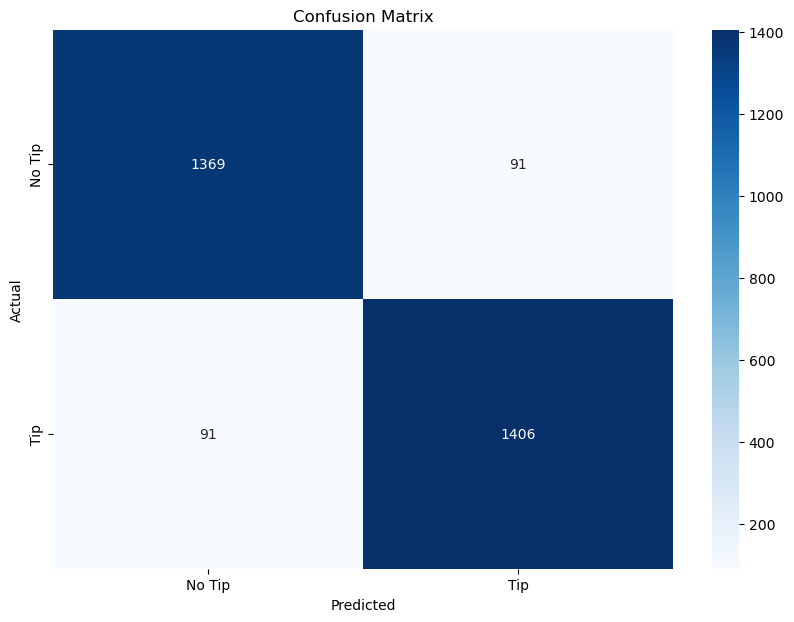

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["No Tip", "Tip"], yticklabels=["No Tip", "Tip"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


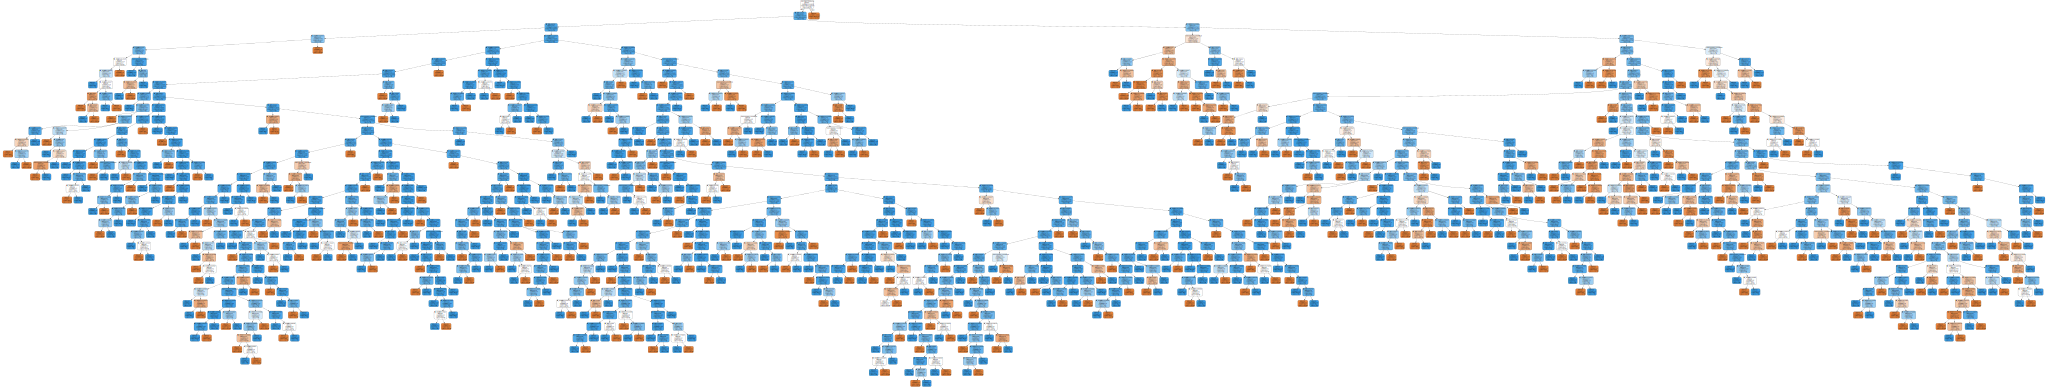

In [12]:
from sklearn import tree
import graphviz

# Generate the tree visualization
tree_vis = tree.export_graphviz(dt_classifier, 
                                out_file=None, 
                                feature_names=features,  
                                class_names=["No Tip", "Tip"],  
                                filled=True, rounded=True,  
                                special_characters=True)  


graph = graphviz.Source(tree_vis)  
graph


In [23]:
#Export to pdf
DT_graph = pydotplus.graph_from_dot_data(tree_vis)
## !!!!  Search for My_DT_tree.pdf on your computer and open it. 
## It will contain your tree ;)
DT_graph.write_pdf("My_DT_tree.pdf")

True

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


best_dt_classifier = grid_search.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.92938689217759


In [14]:
dt_classifier = DecisionTreeClassifier(max_depth=5,random_state=42, criterion='entropy',min_samples_leaf=1,min_samples_split=2)
dt_classifier.fit(X_train, y_train)


y_pred = dt_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9323638823131553
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1460
           1       0.89      0.99      0.94      1497

    accuracy                           0.93      2957
   macro avg       0.94      0.93      0.93      2957
weighted avg       0.94      0.93      0.93      2957



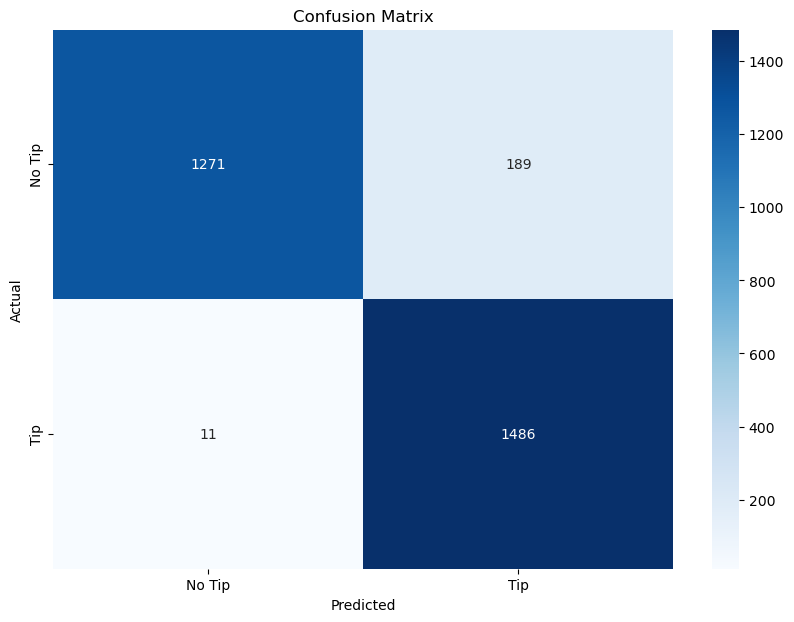

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["No Tip", "Tip"], yticklabels=["No Tip", "Tip"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


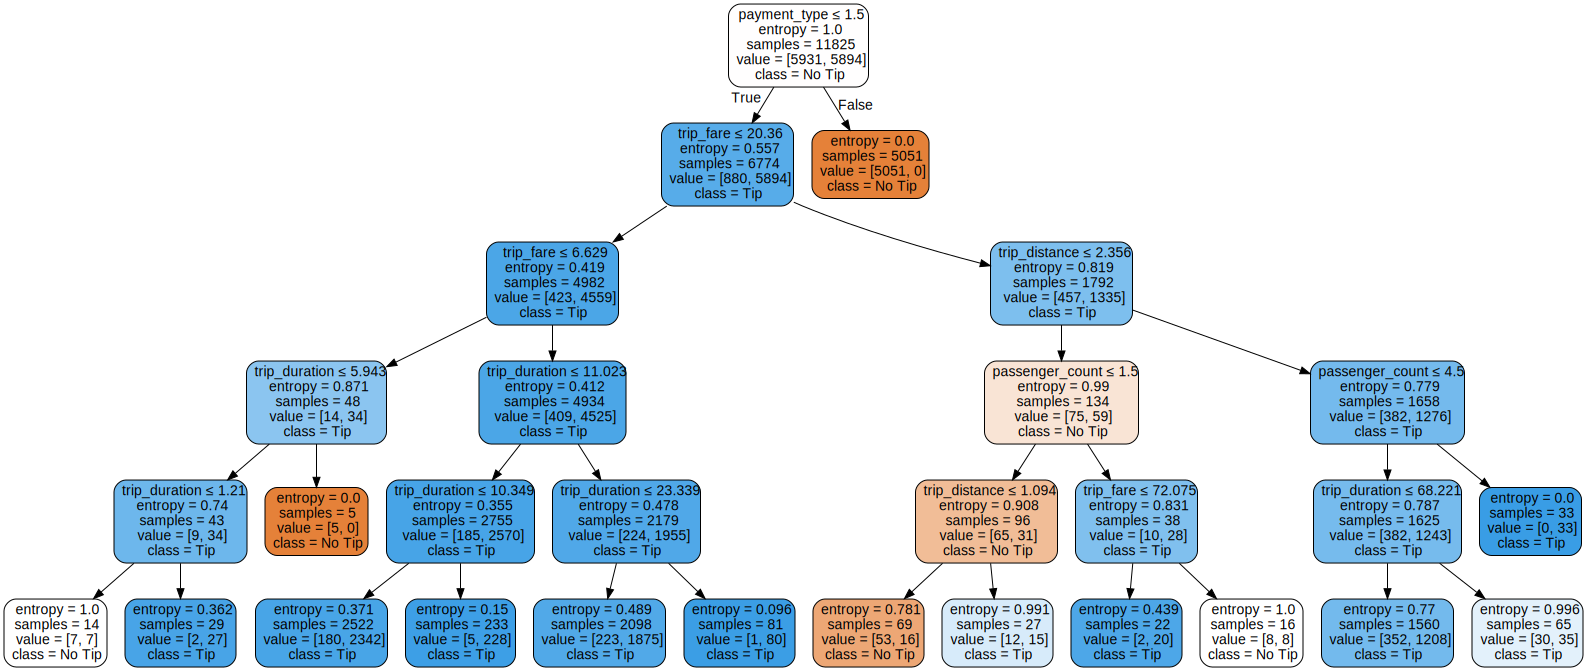

In [16]:
from sklearn import tree
import graphviz

tree_vis = tree.export_graphviz(dt_classifier, 
                                out_file=None, 
                                feature_names=features,  # Use your actual feature names here
                                class_names=["No Tip", "Tip"],  # Assuming binary classification
                                filled=True, rounded=True,  
                                special_characters=True)  

graph = graphviz.Source(tree_vis)  
graph


In [17]:
dt_classifier = DecisionTreeClassifier(max_depth=7,random_state=42, criterion='gini',min_samples_leaf=1,min_samples_split=2)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9330402434900237
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1460
           1       0.89      0.99      0.94      1497

    accuracy                           0.93      2957
   macro avg       0.94      0.93      0.93      2957
weighted avg       0.94      0.93      0.93      2957



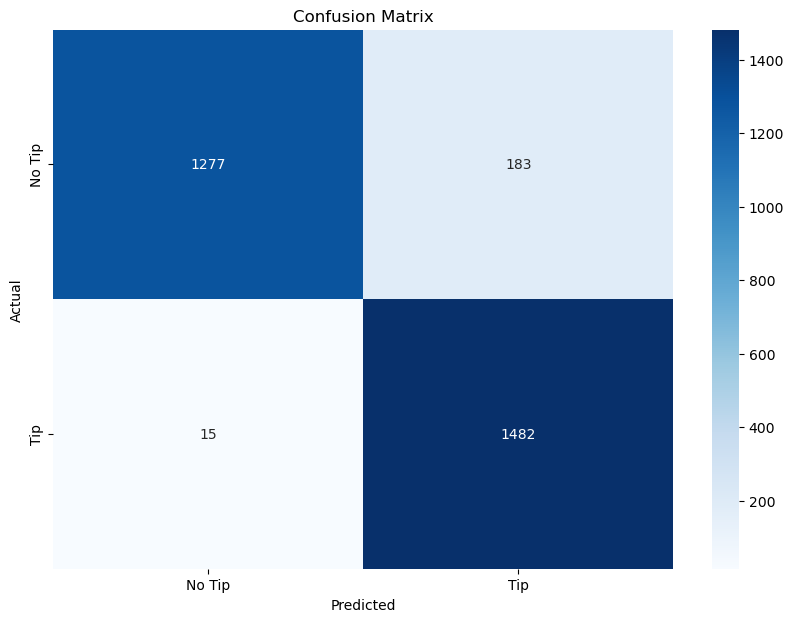

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["No Tip", "Tip"], yticklabels=["No Tip", "Tip"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


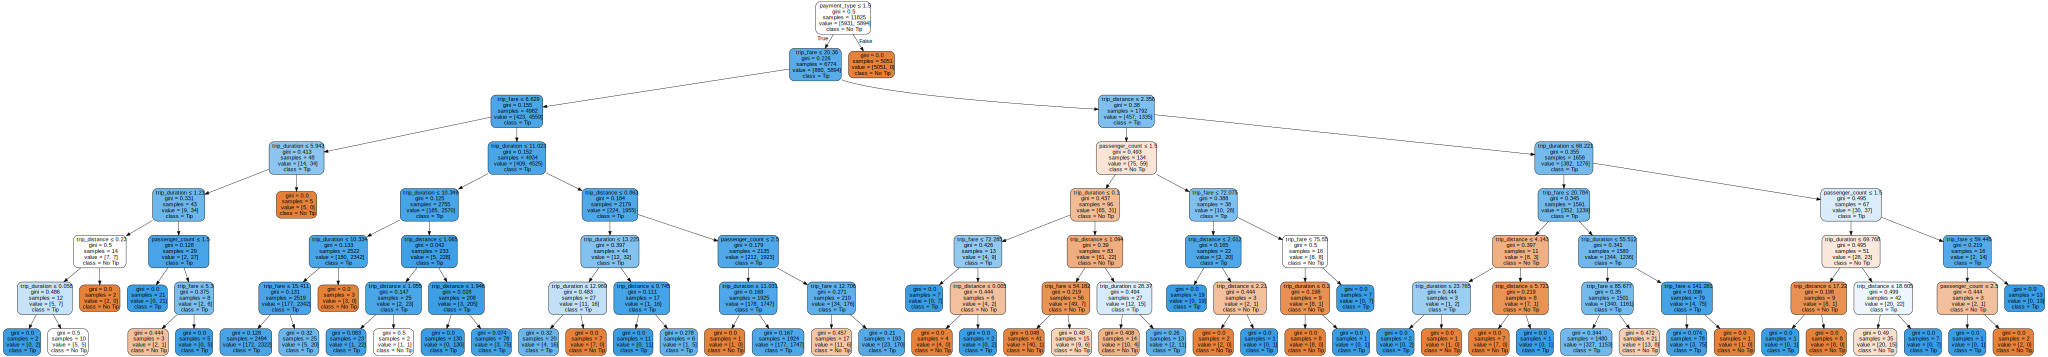

In [19]:
from sklearn import tree
import graphviz

tree_vis = tree.export_graphviz(dt_classifier, 
                                out_file=None, 
                                feature_names=features,  # Use your actual feature names here
                                class_names=["No Tip", "Tip"],  # Assuming binary classification
                                filled=True, rounded=True,  
                                special_characters=True)  

# Create a graph from the tree visualization
graph = graphviz.Source(tree_vis)  
graph


In [21]:
# Print a sample of the complete dataset after SMOTE
print("Sample of the complete dataset after SMOTE:")
print(pd.concat([X_sm, y_sm], axis=1).sample(5))  # Adjust the number of samples as needed



Sample of the complete dataset after SMOTE:
       passenger_count  trip_distance  trip_duration  payment_type  trip_fare  \
2659                 1       1.500000       4.083333             1   9.300000   
9610                 2       0.644119       2.477975             2   7.615688   
5384                 1      10.230000      30.166667             1  40.850000   
13802                1       1.860143      13.848938             2  13.300000   
4824                 1       2.000000      23.583333             1  18.800000   

       tip_given  
2659           1  
9610           0  
5384           1  
13802          0  
4824           1  


In [22]:
# Print a sample from the training set
print("\nSample from the training set:")
print(pd.concat([X_train], axis=1).sample(5))  # Adjust the number of samples as needed

# Print a sample from the testing set
print("\nSample from the testing set:")
print(pd.concat([X_test, y_test], axis=1).sample(5))  # Adjust the number of samples as needed



Sample from the training set:
       passenger_count  trip_distance  trip_duration  payment_type  trip_fare  \
9196                 1       1.400000      15.500000             1      14.30   
4663                 1       2.900000      16.716667             1      16.80   
11592                1       1.005663       5.381446             2       8.80   
6315                 1       0.700000       6.716667             1       9.30   
6190                 1       5.990000       7.416667             2      20.05   

       tip_given  
9196           1  
4663           1  
11592          0  
6315           1  
6190           0  

Sample from the testing set:
       passenger_count  trip_distance  trip_duration  payment_type  trip_fare  \
4962                 1       1.690000      10.000000             2  12.300000   
14386                1       1.914604       1.372730             2  13.394884   
12949                3       0.765289       5.605086             2   9.236296   
7965          